# Hyper

A script to detect the most hyped (popular) bands of a festival

In [1]:
# https://www.dataquest.io/blog/python-pandas-databases/

In [44]:
import sqlite3
import pandas as pd
import string
import unicodedata

## Load Data

In [45]:
# Setup sqlite
sqlite_file = 'hyper.db'

# Connect to the database sqlite file
connection = sqlite3.connect(sqlite_file)
db = connection.cursor()

In [64]:
# get list of bands from db
bands = pd.read_sql_query("SELECT * FROM Bands;", connection)
print("{} bands read".format(len(bands)))
#bands.head()

268 bands read


In [65]:
# read ALL tweets from db
all_tweets = pd.read_sql_query("SELECT * FROM TweetsRaw", connection)
print("{} tweets in db".format(len(all_tweets)))

1094 tweets in db


In [66]:
# read ONLY tweets that have to be processed
tweets_to_process = pd.read_sql_query("SELECT * FROM TweetsRaw WHERE processed IS NULL", connection)
print("{} tweets in db".format(len(tweets_to_process)))

0 tweets in db


In [57]:
# read ONLY tweets that have to be processed
#tweets_to_process = pd.read_sql_query("SELECT tr.* FROM TweetsRaw AS tr \
#                                       LEFT JOIN BandTweets AS bt ON tr.id == bt.tweetRawId \
#                                       WHERE bt.tweetRawId IS NULL", connection)
#print("{} tweets to process".format(len(tweets_to_process)))

In [58]:
#tweets_to_process = tweets_to_process.head(50)
#print("{} tweets to process (!!!REMOVE!!!)".format(len(tweets_to_process)))

## Partition per band

Look for tweets talking about bands and re-create data structure in a band-centered way

In [51]:
def extract_bands(tweet):
    """
    Function that extracts the bands from a tweet text
    Returns a list of bands
    """
    
    # init list to return
    bands_in_tweet = []
    
    # loop all bands and check of any of the written forms is present in the tweet text
    for i, b in bands.iterrows():
                
        # set different band names writing possibilities
        bandname = b['name']
        bandname_lowercase = bandname.lower()
        bandname_lowercase_no_spaces = ''.join(bandname_lowercase.split())
        bandname_lowercase_no_accents = ''.join((c for c in unicodedata.normalize('NFD', bandname_lowercase) if unicodedata.category(c) != 'Mn'))
        bandname_lowercase_no_spaces_no_accents = ''.join((c for c in unicodedata.normalize('NFD', bandname_lowercase_no_spaces) if unicodedata.category(c) != 'Mn'))

        # check if any of the forms is in the tweet text
        if any(s in tweet['tweetText'].lower() for s in [bandname_lowercase, bandname_lowercase_no_spaces, bandname_lowercase_no_accents, bandname_lowercase_no_spaces_no_accents, b['twitterName']]):
            bands_in_tweet.append({"id": b['id'], "codedName": b['codedName']})

    return bands_in_tweet

In [52]:
def band_partition(tweet):
    """
    Function that reads a single tweet info and adds into a list the tweet information partitioned by bands.
    I.e. If a tweet mentions 2 bands, it adds a list of 2 dicts with the tweet info
    """
    
    # loop all bands and add an entry to the list
    for b in tweet['bands']:
        new_band_tweets_list.append({\
                                 "tweetRawId" : tweet['id'],\
                                 "createdAt" : tweet['createdAt'],\
                                 "storedAt" : tweet['storedAt'],\
                                 "bandId" : b['id'],\
                                 "bandCodedName" : b['codedName'],\
                                 "favsCount" : tweet['favsCount'],\
                                 "rtsCount" : tweet['rtsCount'],\
                                 "language" : tweet['language'],\
                                 "userId" : tweet['userId'],\
                                 "userFriendsCount" : tweet['userFriendsCount'],\
                                 "userFollowersCount" : tweet['userFollowersCount'],\
                                 "userStatusesCount" : tweet['userStatusesCount'],\
                                 "userFavsCount" : tweet['userFavsCount'],\
                                 "userLocation" : tweet['userLocation']\
                                })
    
    # Mark TweetsRaw as processed
    db.execute("UPDATE TweetsRaw SET processed = 1 WHERE id == {}".format(tweet.id))
    connection.commit()

In [73]:
if(tweets_to_process.shape[0] > 0):

    # extract bands for each tweet
    tweets_to_process['bands'] = tweets_to_process.apply(extract_bands, axis=1)

    # construct the list of tweets per band
    new_band_tweets_list = []
    tweets_to_process.apply(band_partition, axis=1);

    # create a dataframe from the previous list
    new_band_tweets = pd.DataFrame.from_dict(new_band_tweets_list)
    print("{} band-tweets".format(new_band_tweets.shape[0]))
else:
    new_band_tweets = pd.DataFrame([])
    print("No new tweets to process")

No new tweets to process


In [74]:
# Persist extracted tweets in DB (BandTweets table)
if(new_band_tweets.shape[0] > 0):
    new_band_tweets[['tweetRawId', 'bandId']].to_sql('BandTweets', connection, if_exists='append')
    print("{} new band tweets persisted".format(new_band_tweets.shape[0]))
else:
    print("No new band tweets to persist")

No new band tweets to persist


## Explore Band-Tweet Data

In [61]:
# Construct a dataframe joining data from TweetsRaw and BandTweets
band_tweets = pd.read_sql_query("SELECT bt.bandId, b.codedName AS bandCodedName, tr.* FROM BandTweets AS bt\
                                 LEFT JOIN TweetsRaw AS tr ON bt.tweetRawId == tr.id \
                                 LEFT JOIN Bands AS b ON bt.bandId == b.id", connection)
print("{} band tweets in db".format(band_tweets.shape[0]))

271 band tweets in db


In [62]:
# Count tweets per band
print(band_tweets.groupby('bandCodedName').size().sort_values(ascending=False))

bandCodedName
arcadefire            16
belako                15
frankocean            15
tie                   13
thecrabapples         12
keems                 11
glassanimals          11
!!!                   10
pond                   9
pavvla                 8
macdemarco             7
slayer                 7
solange                7
barbott                6
museless               6
gas                    5
grandaddy              5
thewavepictures        5
clubz                  4
fufanu                 3
mishima                3
polseguera             3
kinggizzard            3
theharlock             3
shellac                3
whitney                2
tourista               2
formation              2
donallop               2
demonaco               2
                      ..
diealright             1
djcoco                 1
7notas7colores         1
aphextwin              1
astronautproject       1
rbp                    1
flyinglotus            1
front242               1
saintetienn

In [63]:
# Count measures of a given band
bandCodedName = 'arcadefire'
print("Tweets about {}:  {}".format(bandCodedName,band_tweets.groupby('bandCodedName').size()[bandCodedName]))
print("Total Favs of {}: {}".format(bandCodedName,band_tweets.groupby('bandCodedName').sum()['favsCount'][bandCodedName]))
print("Total RTs of {}:  {}".format(bandCodedName,band_tweets.groupby('bandCodedName').sum()['rtsCount'][bandCodedName]))

Tweets about arcadefire:  16
Total Favs of arcadefire: 44
Total RTs of arcadefire:  31


## Explore Band-Tweet Timelines

In [100]:
%matplotlib inline
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

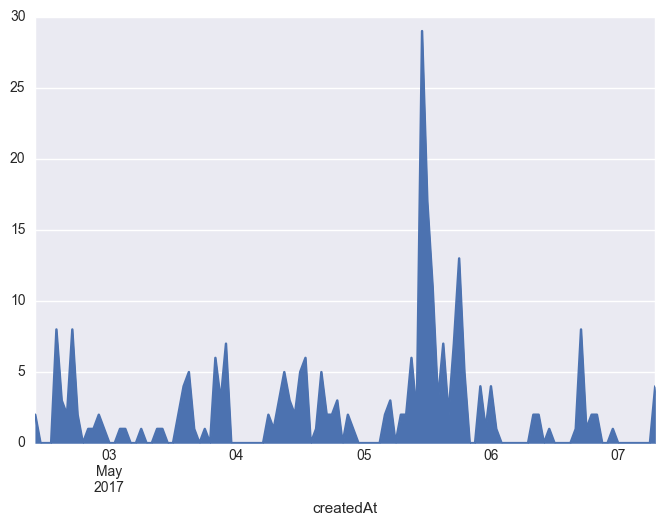

In [101]:
# timeline of tweets - all bands
# https://chrisalbon.com/python/pandas_group_data_by_time.html
band_tweets['createdAt'] = pd.to_datetime(band_tweets['createdAt'], format ='%a %b %d %H:%M:%S +0000 %Y')
band_tweets.index = band_tweets['createdAt']
band_tweets.resample('H').count()['bandId'].plot(kind='area')

/Users/eduard/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


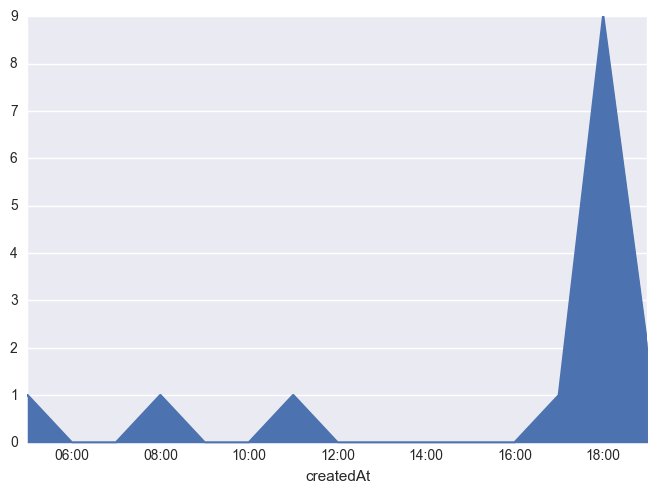

In [102]:
# timeline of tweets - single band
bandCodedName = 'belako'
single_band_tweets = band_tweets[band_tweets['bandCodedName'] == bandCodedName]
single_band_tweets['createdAt'] = pd.to_datetime(single_band_tweets['createdAt'], format ='%a %b %d %H:%M:%S +0000 %Y')
single_band_tweets.index = single_band_tweets['createdAt']
single_band_tweets.resample('H').count()['bandId'].plot(kind='area')

## Hyper Score & Ranking

In [ ]:
# Create the dataframe with one row per band and all the metrics associated

# sort the dataframe by X